# Thread target peptides onto docked helices

### Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders
dig32


### Make a function to thread the targets onto docked helices, replacing the docked helices with a docked target
Try simple threading. The helix is already optimally docked, this method ensures secondary structure shape complimentarity

In [2]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init


@requires_init
def thread_target(packed_pose_in: PackedPose, **kwargs) -> list:
    """
    Replace chB sequence with part of a target sequence
    """
    import bz2
    from itertools import combinations
    import pyrosetta
    from pyrosetta.rosetta.core.pose import Pose
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )
    from pyrosetta.rosetta.protocols.rosetta_scripts import XmlObjects

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            packed_pose_in = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = pyrosetta.distributed.cluster.get_scores_dict(file)["scores"]
    else:
        raise RuntimeError("Need to supply an input")

    target_path = kwargs["target"]
    buried_cutoff = kwargs["cutoff"]

    true_parent_length = int(packed_pose_in.pose.chain_end(1))
    total_length = int(scores["total_length"])  # len(packed_pose_in.pose.residues)
    chB_length = int(total_length - true_parent_length)

    target_name = target_path.split("/")[-1].replace(".pdb", "", 1)
    target_ppose = io.pose_from_file(target_path)
    target_length = len(target_ppose.pose.residues)

    # get all possible threadable sequences
    target_seq = str(target_ppose.pose.sequence())

    if target_length > chB_length:  # need to thread partially
        to_thread = [
            target_seq[x:y]
            for x, y in combinations(range(len(target_seq) + 1), r=2)
            if len(target_seq[x:y]) == chB_length
        ]
        thread_starts = [int(packed_pose_in.pose.chain_begin(2))]
        thread_ends = [int(packed_pose_in.pose.chain_end(2))]
    else:  # need to thread fully, at all possible starts
        to_thread = [target_seq]
        thread_starts = [
            i
            for i in range(
                int(packed_pose_in.pose.chain_begin(2)),
                int(packed_pose_in.pose.chain_end(2)) - target_length + 2,
            )
        ]
        thread_ends = [i + target_length - 1 for i in thread_starts]

    pposes = []

    for seq in to_thread:
        for i, start in enumerate(thread_starts):
            end = thread_ends[i]
            xml = """
            <ROSETTASCRIPTS>
                <SCOREFXNS>
                    <ScoreFunction name="sfxn" weights="beta_nov16" />
                </SCOREFXNS>
                <RESIDUE_SELECTORS>
                    <Chain name="chA" chains="A"/>
                    <Chain name="chB" chains="B"/>
                    <Neighborhood name="interface_chA" selector="chB" distance="10.0" />
                    <Neighborhood name="interface_chB" selector="chA" distance="10.0" />
                    <And name="AB_interface" selectors="interface_chA,interface_chB" />
                    <Not name="not_interface" selector="AB_interface" />
                    <And name="actual_interface_chA" selectors="AB_interface,chA" />
                    <And name="actual_interface_chB" selectors="AB_interface,chB" />
                    <And name="chB_not_interface" selectors="not_interface,chB" />
                    <ResidueName name="pro_and_gly_positions" residue_name3="PRO,GLY" />
                    <ResidueName name="apolar" residue_name3="ALA,CYS,PHE,ILE,LEU,MET,THR,PRO,VAL,TRP,TYR" />
                    <Not name="polar" selector="apolar" />
                    <Layer name="surface" select_core="false" select_boundary="false" select_surface="true" use_sidechain_neighbors="true"/>
                    <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" use_sidechain_neighbors="true"/>
                    <Layer name="core" select_core="true" select_boundary="false" select_surface="false" use_sidechain_neighbors="true"/>
                    <And name="interface_hydrophobics" selectors="AB_interface,apolar,chB,core" />
                    <And name="interface_polars" selectors="AB_interface,polar,chB,core" />
                </RESIDUE_SELECTORS>
                <TASKOPERATIONS>
                </TASKOPERATIONS>
                <SIMPLE_METRICS>
                </SIMPLE_METRICS>
                <MOVERS>
                    <SimpleThreadingMover name="thread" 
                        pack_neighbors="true"
                        neighbor_dis="6.0" start_position="{start}"
                        thread_sequence="{seq}" 
                        scorefxn="sfxn"
                        pack_rounds="2" />
                    <SwitchChainOrder name="delete_B" chain_order="1"/>
                    <SwitchChainOrder name="rechain" chain_order="12"/>
                    <KeepRegionMover name="trim" start="{keep_start}" end="{keep_end}" />
                </MOVERS>
                <FILTERS>
                </FILTERS>
                <PROTOCOLS>
                    <Add mover_name="thread"/>
                </PROTOCOLS>
            </ROSETTASCRIPTS>
            """.format(
                start=start,
                seq=seq,
                keep_start=start,
                keep_end=end,
            )
            threader = SingleoutputRosettaScriptsTask(xml)
            trimmers = XmlObjects.create_from_string(xml)
            chA_only = trimmers.get_mover("delete_B")
            rechain = trimmers.get_mover("rechain")
            trim = trimmers.get_mover("trim")
            threaded_ppose = threader(packed_pose_in.pose.clone())
            threaded_pose = io.to_pose(threaded_ppose)
            chA, chB = threaded_pose.clone(), threaded_pose.clone()
            chA_only.apply(chA)
            if i < len(thread_starts) - 1:
                trim.apply(chB)
            else:
                trim = (
                    pyrosetta.rosetta.protocols.grafting.simple_movers.DeleteRegionMover()
                )
                trim.region(str(chB.chain_begin(1)), str(start - 1))
                trim.apply(chB)
            chA.append_pose_by_jump(chB, chA.num_jump() + 1)
            rechain.apply(chA)
            pyrosetta.rosetta.core.pose.setPoseExtraScore(chA, "chB_length", chB_length)
            pyrosetta.rosetta.core.pose.setPoseExtraScore(
                chA, "chB_start", int(packed_pose_in.pose.chain_begin(2))
            )
            pyrosetta.rosetta.core.pose.setPoseExtraScore(chA, "kept_start", start)
            pyrosetta.rosetta.core.pose.setPoseExtraScore(chA, "kept_end", end)
            pyrosetta.rosetta.core.pose.setPoseExtraScore(chA, "prefix", "")
            pyrosetta.rosetta.core.pose.setPoseExtraScore(chA, "suffix", "")
            pyrosetta.rosetta.core.pose.setPoseExtraScore(chA, "threaded_seq", seq)
            pyrosetta.rosetta.core.pose.setPoseExtraScore(chA, "target_seq", target_seq)
            pyrosetta.rosetta.core.pose.setPoseExtraScore(
                chA, "target_length", target_length
            )
            pyrosetta.rosetta.core.pose.setPoseExtraScore(
                chA, "parent_length", true_parent_length
            )
            int_apolar = trimmers.get_residue_selector("interface_hydrophobics")
            int_apolar_resis = list(int_apolar.apply(chA))
            int_apolar_resis = ",".join(
                [str(i) for i, bool_ in enumerate(int_apolar_resis, start=1) if bool_]
            )
            pyrosetta.rosetta.core.pose.setPoseExtraScore(
                chA, "interface_hydrophobics", int_apolar_resis
            )
            interface_hydrophobic_count = sum(list(int_apolar.apply(chA)))
            pyrosetta.rosetta.core.pose.setPoseExtraScore(
                chA, "interface_hydrophobic_count", interface_hydrophobic_count
            )
            int_polar = trimmers.get_residue_selector("interface_polars")
            interface_polar_count = sum(list(int_polar.apply(chA)))
            pyrosetta.rosetta.core.pose.setPoseExtraScore(
                chA, "interface_polar_count", interface_polar_count
            )
            pyrosetta.rosetta.core.pose.setPoseExtraScore(
                chA, "target_name", target_name
            )
            # in case we want atleast n interfacial contacts
            if interface_hydrophobic_count < buried_cutoff:
                pass
            else:
                pposes.append(io.to_packed(chA))

    if target_length > chB_length:
        new_pposes = []
        for i, ppose in enumerate(pposes):
            pose = io.to_pose(ppose)
            prefix, suffix = (
                pose.scores["target_seq"].split(pose.scores["threaded_seq"])[0],
                pose.scores["target_seq"].split(pose.scores["threaded_seq"])[-1],
            )
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "prefix", f"{prefix}")
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, "suffix", f"{suffix}")
            new_pposes.append(io.to_packed(pose))
        pposes = new_pposes
    else:
        pass

    final_pposes = []
    for ppose in pposes:
        pose = io.to_pose(ppose)
        final_scores = {**scores, **dict(pose.scores)}
        for key, value in final_scores.items():
            pyrosetta.rosetta.core.pose.setPoseExtraScore(pose, key, str(value))
        final_pposes.append(io.to_packed(pose))
    return final_pposes

### Setup dask, set command line options, make tasks and submit to client again to test msd
all filtered stapled helix binders vs all targets

In [3]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)


def create_tasks(scaffolds, targets, options):
    with open(scaffolds, "r") as f:
        for file in f:
            for target in targets:
                tasks = {"options": "-corrections::beta_nov16 true"}
                tasks["extra_options"] = options
                tasks["-s"] = file.rstrip()
                tasks["target"] = target
                if "covstem" in target:
                    tasks["cutoff"] = 2
                else:
                    tasks["cutoff"] = 3
                yield tasks


logging.basicConfig(level=logging.INFO)
scaffolds = os.path.join(os.getcwd(), "00_inputs/best_nozero.list")
targets = glob(os.path.join(os.getcwd(), "00_inputs/targets/0/*.pdb"))


options = {
    "-out:level": "300",
}

output_path = os.path.join(os.getcwd(), "00_thread_targets")

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="8GB",
        queue="medium",
        walltime="23:30:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "23h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-150 workers,
        cluster.adapt(
            minimum=1,
            maximum=150,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=create_tasks(scaffolds, targets, options),
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
            ).distribute(protocols=[thread_target])

run the following from your local terminal:
ssh -L 8000:localhost:8787 pleung@dig65
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.err
#SBATCH -o /mnt/home/pleung/logs/slurm_logs/dask-worker-%J.out
#SBATCH -p medium
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=8G
#SBATCH -t 23:30:00

JOB_ID=${SLURM_JOB_ID%;*}

/home/pleung/.conda/envs/phil/bin/python -m distributed.cli.dask_worker tcp://172.16.131.95:40109 --nthreads 1 --memory-limit 7.45GiB --name name --nanny --death-timeout 120 --local-directory $TMPDIR/dask --lifetime 23h --lifetime-stagger 4m

<Client: 'tcp://172.16.131.95:40109' processes=0 threads=0, memory=0 B>


INFO:pyrosetta.distributed:maybe_init performing pyrosetta initialization: {'options': '-run:constant_seed 1 -multithreading:total_threads 1', 'extra_options': '-mute all', 'set_logging_handler': 'interactive', 'silent': True}
INFO:pyrosetta.rosetta:Found rosetta database at: /home/pleung/.conda/envs/phil/lib/python3.8/site-packages/pyrosetta/database; using it....
INFO:pyrosetta.rosetta:PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.12+release.ed6a5560506cfd327d4a6a3e2c9b0c9f6f4a6535 2021-03-26T16:09:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/distributed/utils.py", line 668, in log_errors
    yield
  File "/home/pleung/.conda/envs/phil/lib/python3.8/site-packages/distributed/scheduler.py", line 574

### Look at scores
Hacky function to load JSON-like data

In [2]:
%%time
def read_scorefile(scores):
    import pandas as pd
    from tqdm import tqdm
    dfs = []
    with open(scores, "r") as f:
        for line in tqdm(f):
            dfs.append(pd.read_json(line).T)
    tabulated_scores = pd.concat(dfs)
    return tabulated_scores


output_path = os.path.join(os.getcwd(), "00_thread_targets")
scores = os.path.join(output_path, "scores.json")
scores_df = read_scorefile(scores)

41813it [04:40, 148.99it/s]


CPU times: user 4min 48s, sys: 2.17 s, total: 4min 50s
Wall time: 4min 54s


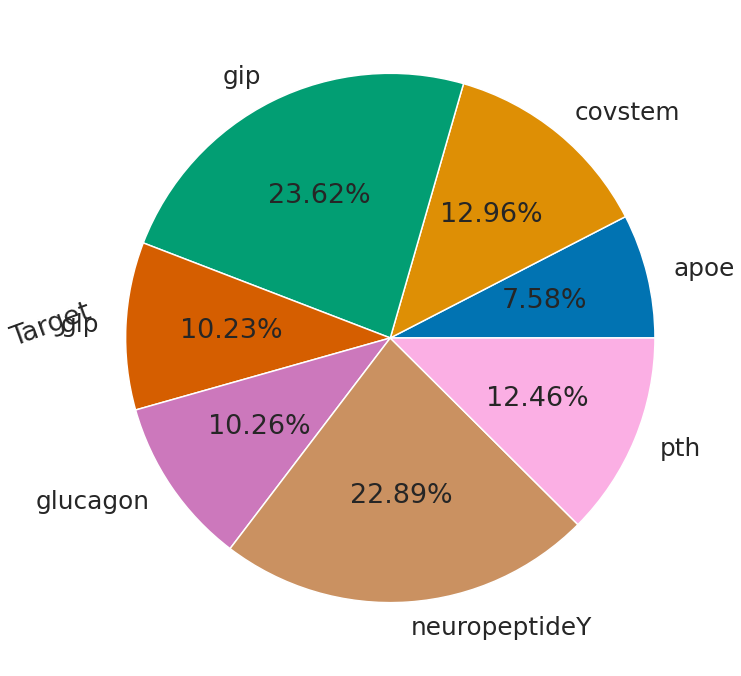

In [7]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)
os.makedirs(os.path.join(os.getcwd(), "figs"), exist_ok=True)
(
    fig,
    ax1,
) = plt.subplots(ncols=1, figsize=(20, 10), tight_layout=True)
scores_df.groupby("target_name").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
ax1.set_title("Target")
plt.savefig("figs/00_docked_targets.png")

### What are the distributions of the starting docks?

In [8]:
scores_df.columns

Index(['9mer', 'abego_str', 'bb_clash', 'chB_length', 'chB_start',
       'closure_type', 'cmsa_AB', 'cmsa_AC', 'cmsa_BC', 'cmsa_int',
       'disulfide_at', 'docked_helix', 'dslf_fa13', 'dslf_fa13_cart', 'dssp',
       'fa_atr', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi', 'fa_elec',
       'fa_intra_atr_xover4', 'fa_intra_elec', 'fa_intra_rep_xover4',
       'fa_intra_sol_xover4', 'fa_rep', 'fa_sol', 'geometry', 'geometry_loop',
       'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc', 'hbond_sr_bb', 'hxl_tors',
       'interface_buried_sasa', 'interface_hydrophobic_count',
       'interface_hydrophobics', 'interface_polar_count', 'kept_end',
       'kept_start', 'lk_ball', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
       'lk_ball_iso', 'new_loop_resis', 'nmodes_attempts', 'omega', 'p_aa_pp',
       'parent', 'parent_length', 'pivot_helix', 'pre_break_helix', 'prefix',
       'pro_close', 'rama_prepro', 'ref', 'rmsd_cart', 'rmsd_dual', 'rmsd_nmp',
       'sasa_AB', 'sasa_AC', 'sasa_BC', 'sasa_i

In [10]:
for score in "interface_hydrophobic_count interface_polar_count".split():
    fig = plt.figure(figsize=(20, 10), tight_layout=True)
    sns.histplot(x=score, data=scores_df, hue="target_name", multiple="fill")
    fig.savefig(f"figs/00_{score}.png")
    plt.close()

In [21]:
for name in set(scores_df.target_name.values):
    fig, ax = plt.subplots(ncols=1, figsize=(20, 20), tight_layout=True)
    sns.histplot(
        ax=ax,
        data=scores_df[scores_df["target_name"] == name],
        x="interface_hydrophobic_count",
        y="interface_polar_count",
    )
    fig.suptitle(f"interface counts {name}")
    fig.savefig(f"figs/00_interface_counts_{name}.png")
    plt.close()

In [22]:
scores_df["interface_net_count"] = (
    scores_df["interface_hydrophobic_count"] - scores_df["interface_polar_count"]
)
for name in set(scores_df.target_name.values):
    fig, ax = plt.subplots(ncols=1, figsize=(20, 20), tight_layout=True)
    sns.histplot(
        ax=ax,
        data=scores_df[scores_df["target_name"] == name],
        x="interface_net_count",
    )
    fig.suptitle(f"interface net count {name}")
    fig.savefig(f"figs/00_interface_net_count_{name}.png")
    plt.close()

### We want to get the docks with low interface hydrophobics and high interface polars

In [23]:
good_df = scores_df[scores_df["interface_net_count"] >= 0]
len(good_df)

32938

In [25]:
for name in set(scores_df.target_name.values):
    subset = good_df[good_df["target_name"] == name]
    out_path = os.path.join(os.getcwd(), "00_thread_targets")
    print(name, len(subset))
    with open(os.path.join(out_path, f"{name}.list"), "w+") as f:
        for decoy in subset.index:
            print(decoy, file=f)

neuropeptideY 8282
pth 3302
glucagon 2988
gip 6609
covstem 5080
apoe 2804
glp 3873


### Unused blocks

In [83]:
    def append_or_prepend(input_pose: Pose, prepend: bool, seq_in: str) -> Pose:
        def find_chain_termini(pose: Pose, chain: str) -> tuple:
            chain2int = {"A": 1, "B": 2, "C": 3, "D": 4}
            start = pose.chain_begin(chain2int[chain])
            end = pose.chain_end(chain2int[chain])
            return start, end

        if len(seq_in) == 0:
            return input_pose
        else:
            pass

        chain = "B"
        pose = pyrosetta.Pose()
        pose.detached_copy(input_pose)

        # ok. Since floppy tail doesn't like it likes not working on chain B.
        scom = pyrosetta.rosetta.protocols.simple_moves.SwitchChainOrderMover()

        original_chain_order = "".join(
            [str(i) for i in pyrosetta.rosetta.core.pose.get_chains(pose)]
        )
        print("original chain order: ", original_chain_order)

        mod_chain_num = str(ord(chain.upper()) - ord("A") + 1)

        new_chain_order = ""
        for ci in original_chain_order:
            if ci == mod_chain_num:
                new_chain_order = ci + new_chain_order
            else:
                new_chain_order = new_chain_order + ci
        print("new chain order: ", new_chain_order)

        scom.chain_order(new_chain_order)
        scom.apply(pose)
        order = scom.chain_order(pose)
        print(order)
        chain_nterm, chain_cterm = find_chain_termini(pose, chain)

        # get type set to generate residues
        res_type_set = pose.residue_type_set_for_pose()
        # replace current terminal residue, with non-terminal variant
        # then extend terminus
        if prepend:
            for i in range(len(seq_in)):
                new_res = seq_in[::-1][i]
                print(f"ADDING #{i} {new_res}")
                res_type = res_type_set.get_representative_type_name1(new_res)
                print(res_type)
                res = pyrosetta.rosetta.core.conformation.ResidueFactory.create_residue(
                    res_type
                )
                print(res)
                pro_flag = False

                n_term_pos = find_chain_termini(pose, chain)[0]
                print(f"n_term_pos {n_term_pos}")
                n_term_res = pose.residue(n_term_pos)
                print(f"EXISTING RES: {n_term_res.name3()}")
                if n_term_res.name3() == "PRO":
                    gly_res_type = res_type_set.get_representative_type_name1("G")
                    pro_res_type = res_type_set.get_representative_type_name1("P")
                    pro_flag = True

                    # pro_holder = n_term_res.clone() #could it have changed? use this func to be safe. #Do I need to make a copy?
                    pro_holder = pyrosetta.rosetta.core.conformation.ResidueFactory.create_residue(
                        pro_res_type
                    )
                    gly = pyrosetta.rosetta.core.conformation.ResidueFactory.create_residue(
                        gly_res_type
                    )
                    print(gly)
                    print(type(gly))
                    pose.replace_residue(n_term_pos, gly, True)
                    print(pose)
                pose.conformation().safely_prepend_polymer_residue_before_seqpos(
                    res, chain_nterm, True
                )
                if pro_flag:
                    # reset to pro, which is now one res up
                    pose.replace_residue(n_term_pos + 1, pro_holder, True)
                    print(pose)
        else:
            for i in range(len(seq_in)):
                print("appending", seq_in[i])
                res_type = res_type_set.get_representative_type_name1(seq_in[i])
                res = pyrosetta.rosetta.core.conformation.ResidueFactory.create_residue(
                    res_type
                )
                pose.conformation().safely_append_polymer_residue_after_seqpos(
                    res, chain_cterm + i, True
                )
        # iterate over new residues and set bb angles, but don't move "old" residues
        movemap = pyrosetta.MoveMap()

        flexible_start_resnum = 0
        flexible_stop_resnum = 0

        # regions to repack / extend are the tail
        if not prepend:
            movemap.set_bb_true_range(chain_cterm + 1, chain_cterm + len(seq_in))
            movemap.set_chi_true_range(chain_cterm + 1, chain_cterm + len(seq_in))
            flexible_start_resnum = chain_cterm + 1
            flexible_stop_resnum = chain_cterm + len(seq_in)

        else:
            # reverse fold tree to not perturb input
            ft = pose.fold_tree()
            ft.reorder(chain_nterm + len(seq_in))
            pose.fold_tree(ft)
            movemap.set_bb_true_range(chain_nterm, chain_nterm + len(seq_in) - 1)
            movemap.set_chi_true_range(chain_nterm, chain_nterm + len(seq_in) - 1)
            flexible_start_resnum = chain_nterm
            flexible_stop_resnum = chain_nterm + len(seq_in) - 1

        print(movemap)

        # let's test some things
        print("Setting ideal beta strand backbone angles for...")

        for i in range(1, pose.size() + 1, 1):
            if movemap.get_bb(i):
                print(i, pose.pdb_info().pose2pdb(i))
                pose.set_phi(i, -57.8)
                pose.set_psi(i, -47.0)
                pose.set_omega(i, 180)

        print("done idealizing")

        #         ##score and repack extended strand, 5 residues into the pose on the end that got extended, and
        #         sfxn = pyrosetta.get_fa_scorefxn()

        #         task = pyrosetta.rosetta.core.pack.task.TaskFactory.create_packer_task(pose)
        #         task.restrict_to_repacking()

        #         pack_rotamers = (
        #             pyrosetta.rosetta.protocols.minimization_packing.PackRotamersMover(
        #                 sfxn, task
        #             )
        #         )
        #         print("begin packing")
        #         pack_rotamers.apply(pose)
        #         print("done packing")

        #         # ugh gotta reinit rosetta for floppy tail
        #         options = "-corrections::beta_nov16 true "
        #         if prepend:
        #             options += "-FloppyTail::C_root 1 "
        #         else:
        #             options += "-FloppyTail::COM_root 1 "
        #         options += "-FloppyTail::perturb_temp 0.8 "
        #         options += "-FloppyTail::perturb_cycles 5000 "  # was 5k
        #         options += "-FloppyTail::perturb_show 0 "
        #         options += "-FloppyTail::debug 0 "
        #         options += "-FloppyTail::refine_temp 0.8 "
        #         options += "-FloppyTail::refine_cycles 0 "
        #         options += "-FloppyTail::refine_repack_cycles 30 "
        #         options += "-packing::repack_only 1 "

        #         pyrosetta.init(options)

        #         ftm = pyrosetta.rosetta.protocols.floppy_tail.FloppyTailMover()
        #         ftm.set_movemap(movemap)
        #         # does floppy tail not work if chain != A?
        #         print("begin ftm")
        #         ftm.apply(pose)
        #         print("ftm finished")
        # reset chain order
        scom.chain_order(original_chain_order)
        scom.apply(pose)
        order = scom.chain_order(pose)
        print(order)
        # and now need to refix pdb numbering
        pyrosetta.rosetta.core.pose.renumber_pdbinfo_based_on_conf_chains(pose)
        print("flop_chain finished")

        return pose

26

In [ ]:
%%time
import pyrosetta
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

flags = """
-out:level 300
-corrections::beta_nov16 true
-holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
-indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5
"""
pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
t = thread_target(
    None,
    **{
        "-s": "/mnt/home/pleung/projects/bistable_bundle/r4/helix_binders/04_pack_staple_pair/decoys/0000/2021.06.15.13.01.19.064071_4aa9969e42994d8980fa4971907076d0.pdb.bz2",
#         "target": "/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/00_inputs/targets/0/pth.pdb",
        "target": "/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/00_inputs/targets/0/covstem.pdb",
        "cutoff": 3,
    }
)